**Summary**

    0.0 Data Preparation
        0.1 Data scaling
    1.0 Choosing Quantity of Clusters
    2.0 Modeling
    3.0 Analysis
    3.1 Looking for cluster peculiarity.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import zscore

from joblib import dump, load

In [2]:
def fig(x=10, y=8):
    plt.figure(figsize=(x, y))

In [3]:
raw_data = pd.read_pickle("data/data_to_ml.pkl")
raw_data.sample()

,year_birth,education,marital_status,income,kidhome,teenhome,dt_customer,recency,mnt_wines,mnt_fruits,...,age,spent_percentage_wines,spent_percentage_fruits,spent_percentage_meat,spent_percentage_fish,spent_percentage_sweet,spent_percentage_gold,percentage_web_purchases,percentage_catalog_purchases,percentage_store_purchases
914,1994,Graduation,Single,95529.0,0,0,2012-12-03,29,770,29,...,20,0.391658,0.014751,0.452696,0.127162,0.013733,0.012208,0.411765,0.176471,0.411765


## 0.0 Data Preparation

In [4]:
boruta_columns = ['recency', 'mnt_wines', 'mnt_meat_products', 'spent_percentage_meat',
                  'spent_percentage_gold', 'percentage_store_purchases']
data = raw_data[boruta_columns].copy()
df_cluster = raw_data.copy()

### 0.1 Data scaling

In [5]:
columns = data.select_dtypes(include=['int64', 'float64']).columns

In [6]:
min_max_scaler = MinMaxScaler() # range(0, 1)

for column in columns:
    if column != 'response':
        data[column] = min_max_scaler.fit_transform(data[[column]].values) 

### 0.2 Feature Encoding

In [664]:
# codes = {'Basic':0, '2n Cycle':1, 'Graduation':2, 'Master':3, 'PhD':4}
# data['education'] = data['education'].map( codes )

# data = pd.get_dummies( data, prefix=['marital_status'], columns=['marital_status'] )

## 1.0 Choosing Quantity of Clusters

[Just](https://towardsdatascience.com/an-introduction-to-clustering-algorithms-in-python-123438574097)
[Some](https://machinelearningmastery.com/clustering-algorithms-with-python/)
[References](https://realpython.com/k-means-clustering-python/)

In [7]:
X = data.copy()
# X.drop(columns='dt_customer', inplace=True)

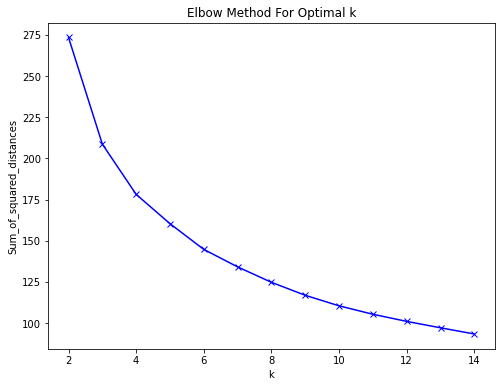

In [9]:
sum_of_squared_distances = []
K = range(2,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    sum_of_squared_distances.append(km.inertia_)

plt.figure(figsize=(8,6))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

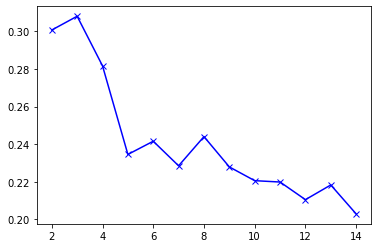

In [667]:
sil = []
for k in K:
    kmeans = KMeans(n_clusters = k).fit(X)
    labels = kmeans.labels_
    sil.append(silhouette_score(X, labels, metric = 'euclidean'))
plt.plot(K, sil, 'bx-');

## 2.0 Modeling

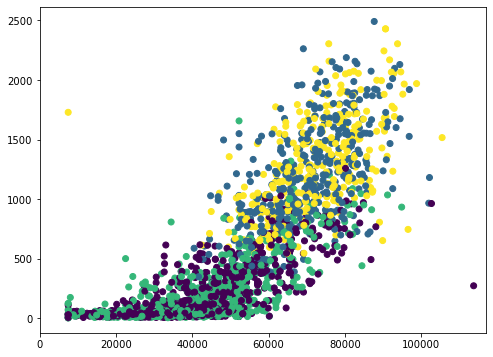

In [85]:
kmeans = KMeans(n_clusters=4, max_iter=1000)
labels = kmeans.fit_predict(X)
df_cluster['cluster'] = labels

plt.figure(figsize=(8,6))
plt.scatter(df_cluster['income'], df_cluster['amount_spent'], c=df_cluster['cluster'])
plt.xlim(-1, 117000);

Trying to find clusters with more target customers.

In [86]:
clusters = df_cluster.groupby('cluster').agg(['count','sum','median','mean']).response

,count,sum,median,mean
cluster,,,,
0,698,106,0,0.151862
1,389,65,0,0.167095
2,656,33,0,0.050305
3,313,108,0,0.345048


In [705]:
# dump(kmeans, 'models/kmeans_3c.joblib') # n_clusters=3

## 3.0 Analysis 
### 3.1 Looking for cluster peculiarity.

In [8]:
kmeans = load('models/kmeans_3c.joblib')

In [9]:
df_cluster['cluster'] = kmeans.predict(X)

clustering = {0:'targeted', 1:'hidden_t', 2:'untargeted'}
df_cluster['cluster'] = df_cluster['cluster'].map(clustering)

df_cluster.groupby('cluster').response.agg(['count', 'sum','mean'])

,count,sum,mean
cluster,,,
hidden_t,800,138,0.172500
targeted,457,134,0.293217
untargeted,799,40,0.050063


In [10]:
targeted = df_cluster[df_cluster['cluster'] == 'targeted']
untargeted = df_cluster[df_cluster['cluster'] == 'untargeted']
hidden_target = df_cluster[df_cluster['cluster'] == 'hidden_t']

In [11]:
selected_columns = ['recency', 'income', 'mnt_wines', 'mnt_fruits', 'mnt_meat_products', 'mnt_fish_products',
                    'mnt_sweet_products', 'mnt_gold_prods', 'num_deals_purchases', 'num_web_purchases', 
                    'num_catalog_purchases', 'num_store_purchases', 'num_purchases', 'num_web_visits_month',
                    'amount_spent', 'loyalty_time_days', 'mean_amount_spent_per_month', 'age',
                    'spent_percentage_wines', 'spent_percentage_fruits', 'spent_percentage_meat',
                    'spent_percentage_fish', 'spent_percentage_sweet', 'spent_percentage_gold',
                    'percentage_web_purchases', 'percentage_catalog_purchases', 'percentage_store_purchases']
len(selected_columns)

27

In [12]:
z_scores = zscore(df_cluster.drop(columns=['dt_customer','marital_status','education','cluster']))
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_df = df_cluster[filtered_entries]

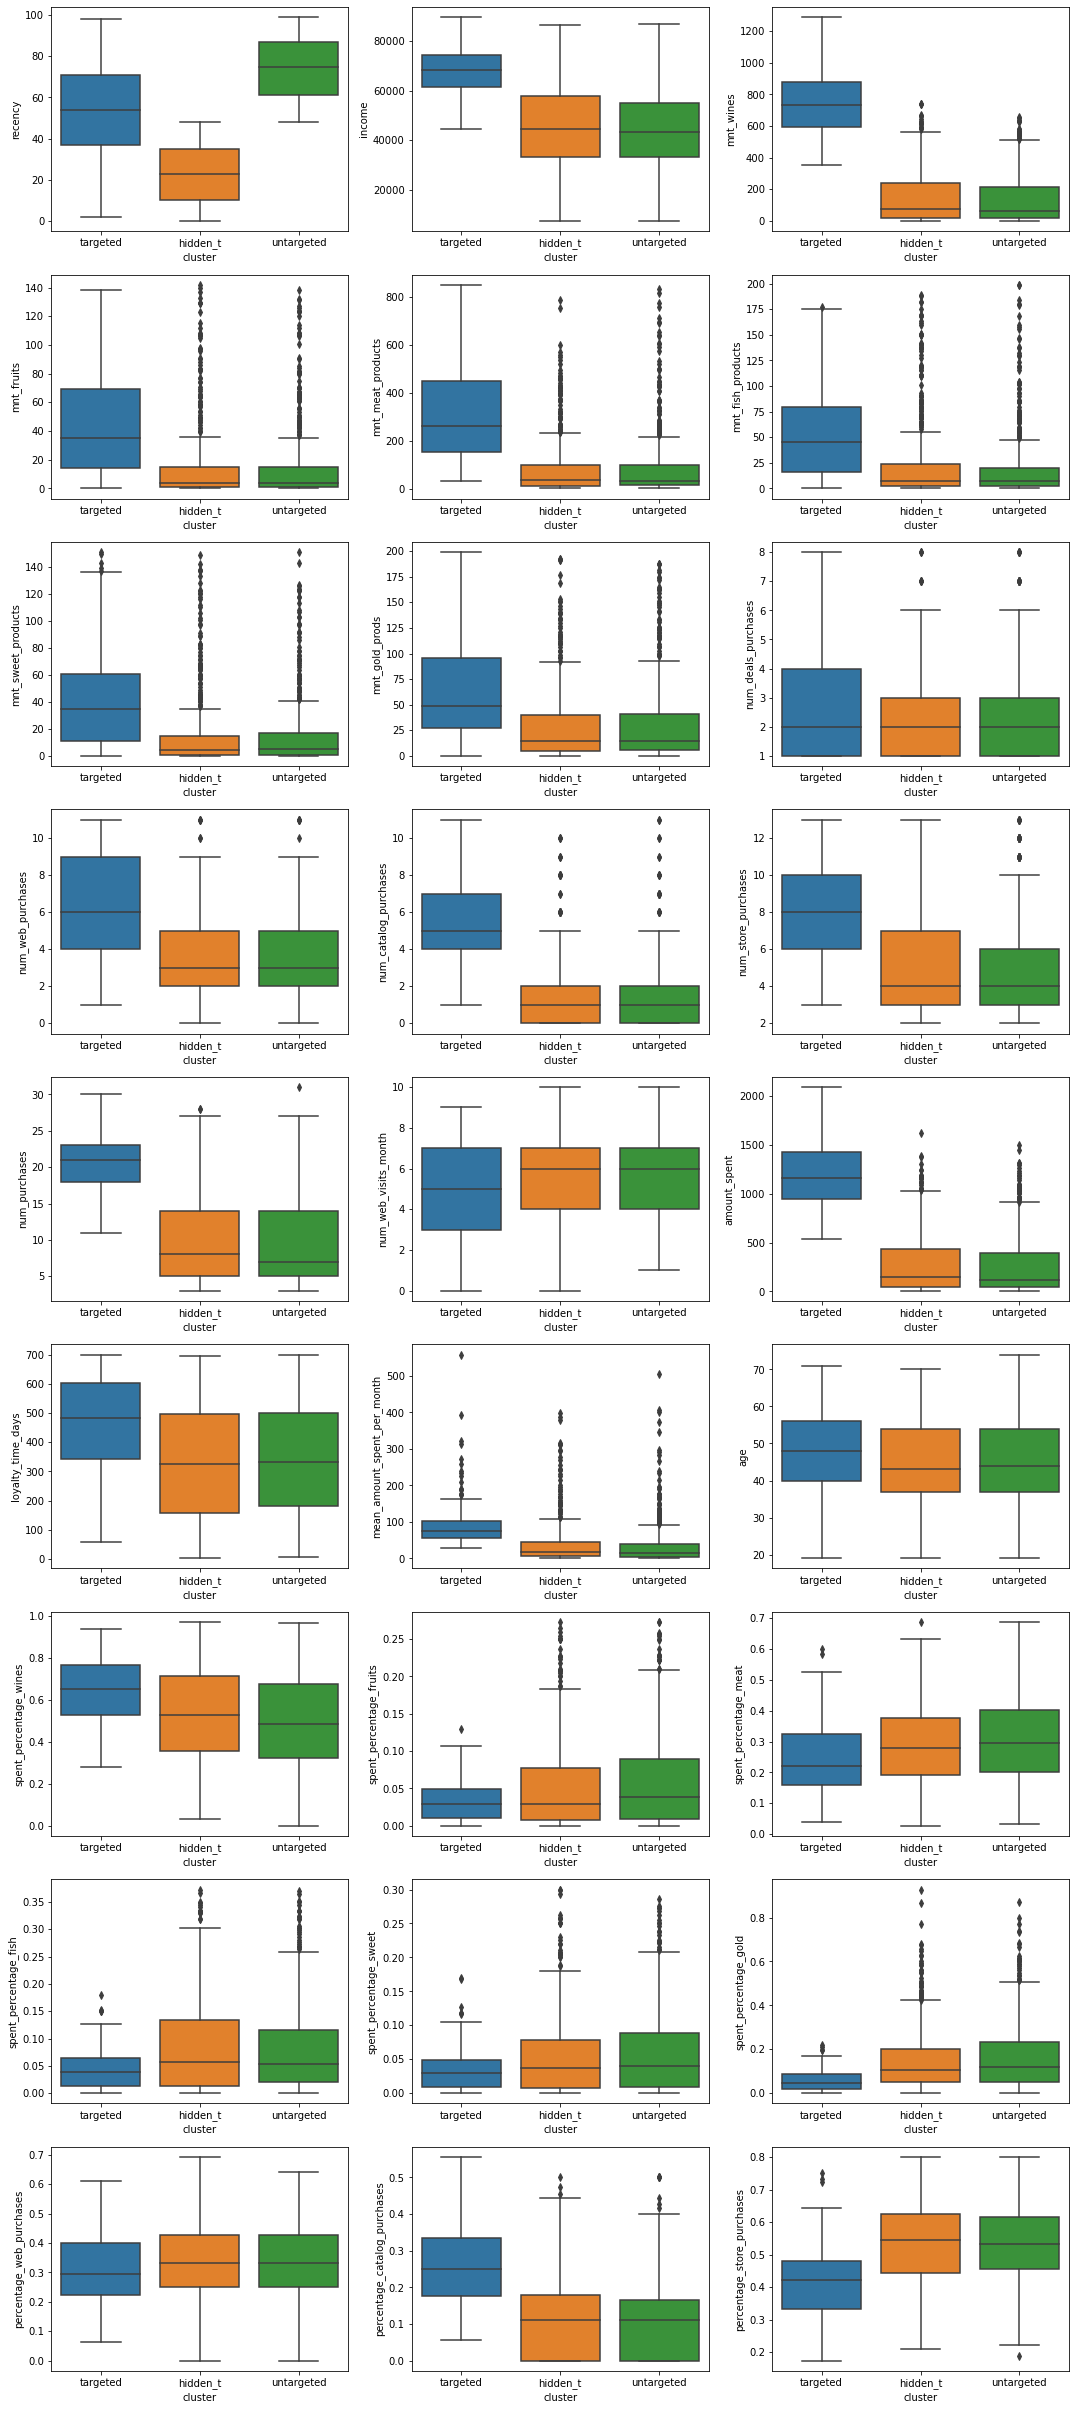

In [16]:
rows = len(selected_columns); columns = 3; plot = 0
plt.figure(figsize=(15, 100))
for attribute in selected_columns:
    plot += 1    
    plt.subplot( rows, columns, plot )
    sns.boxplot(data=new_df, x='cluster', y=attribute, palette='tab10', showfliers=True)
plt.tight_layout()

### Recency 
_number of days since the last purchase_

- **untargeted**
        More than 48 days passed since last purchase

### Income
_customer's yearly household income_

- **targeted** 
        Above R$ 50,000        


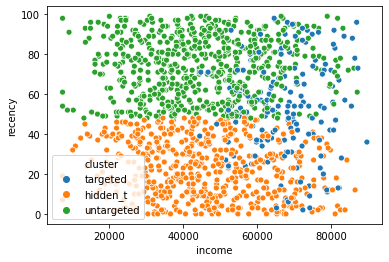

In [20]:
sns.scatterplot(data=new_df, x='income', y='recency', hue='cluster', palette='tab10');

In [36]:
untargeted['recency'].min()

48

In [31]:
targeted['income'].quantile(0.01)

47560.6

### Amount Wines 
_amount spent on wines products in the last 2 years_

- **targeted**
        Over 455
- **untargeted**
        Under 455
- **hidden_t**
        Under 455
        
['amount_spent', 'mean_amount_spent_per_month', 'spent_percentage_fruits', 'spent_percentage_fish', 
 'spent_percentage_sweet', 'spent_percentage_gold']

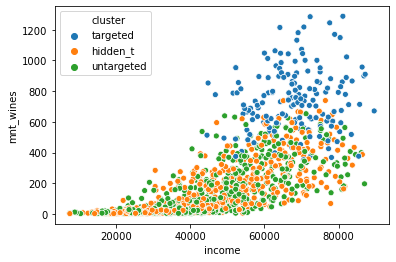

In [22]:
sns.scatterplot(data=new_df, x='income', y='mnt_wines', hue='cluster', palette='tab10');

In [28]:
targeted['mnt_wines'].quantile(0.01)

375.55999999999995

In [35]:
pd.DataFrame( df_cluster.groupby('cluster')['mnt_wines'].quantile(.95) )

,mnt_wines
cluster,
hidden_t,531.05
targeted,1280.20
untargeted,505.30


### Amount Fruits
_amount spent on fruits products in the last 2 years_

- **targeted, untargeted, hidden_t**
        They are all scattered, but 75% of untargeted and hidden_t customers has bought fewer than 19 fruits.

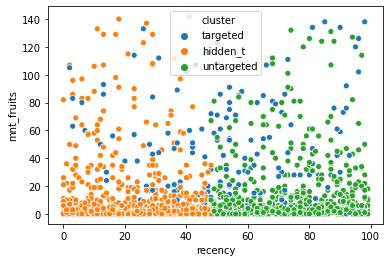

In [39]:
sns.scatterplot(data=new_df, x='recency', y='mnt_fruits', hue='cluster', palette='tab10');

In [43]:
pd.DataFrame( df_cluster.groupby('cluster')['mnt_fruits'].describe() )

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
hidden_t,800.0,19.920000,36.371482,0.0,1.0,5.0,19.0,199.0
targeted,457.0,50.975930,46.756947,0.0,15.0,35.0,76.0,185.0
untargeted,799.0,18.459324,32.358278,0.0,1.0,5.0,19.0,194.0


In [43]:
pd.DataFrame( df_cluster.groupby('cluster')['mnt_fruits'].quantile(.9) )

,mnt_fruits
cluster,
hidden_t,60.0
targeted,127.8
untargeted,55.2


### Amount Meat
_amount spent on meat products in the last 2 years_

        The same as in Fruits (but fewer than 120 products).


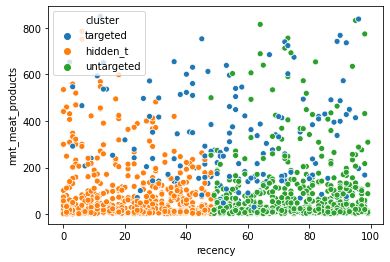

In [47]:
sns.scatterplot(data=new_df, x='recency', y='mnt_meat_products', hue='cluster', palette='tab10');

In [92]:
pd.DataFrame( df_cluster.groupby('cluster')['mnt_meat_products'].describe() )

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
hidden_t,800.0,107.523750,176.281780,0.0,11.0,35.5,124.0,1725.0
targeted,457.0,385.892779,258.421201,24.0,162.0,348.0,558.0,1725.0
untargeted,799.0,103.491865,173.247884,1.0,13.0,31.0,113.0,1607.0


In [44]:
pd.DataFrame( df_cluster.groupby('cluster')['mnt_meat_products'].quantile(.9) )

,mnt_meat_products
cluster,
hidden_t,300.3
targeted,768.0
untargeted,282.0


### Amount Fish
_amount spent on fish products in the last 2 years_

        75% of customers have bought a maximum of 28 products.

In [95]:
pd.DataFrame( df_cluster.groupby('cluster')['mnt_fish_products'].describe() )

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
hidden_t,800.0,28.462500,47.758949,0.0,2.0,7.0,28.25,259.0
targeted,457.0,71.498906,64.703376,0.0,19.0,52.0,104.00,258.0
untargeted,799.0,26.728411,46.505532,0.0,2.0,7.0,28.00,254.0


In [51]:
pd.DataFrame( df_cluster.groupby('cluster')['mnt_fish_products'].quantile(.9) )

,mnt_fish_products
cluster,
hidden_t,90.1
targeted,177.8
untargeted,84.0


### Amount Sweets
_amount spent on sweet products in the last 2 years_

        75% of customers have bought a maximum of 20 products.

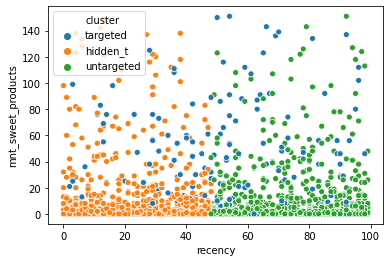

In [54]:
sns.scatterplot(data=new_df, x='recency', y='mnt_sweet_products', hue='cluster', palette='tab10');

In [109]:
pd.DataFrame( df_cluster.groupby('cluster')['mnt_sweet_products'].describe() )

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
hidden_t,800.0,19.992500,36.694285,0.0,1.0,5.0,20.0,263.0
targeted,457.0,52.689278,49.825614,0.0,13.0,38.0,80.0,196.0
untargeted,799.0,19.824781,35.199316,0.0,1.0,6.0,20.0,195.0


In [50]:
pd.DataFrame( df_cluster.groupby('cluster')['mnt_sweet_products'].quantile(.9) )

,mnt_sweet_products
cluster,
hidden_t,64.0
targeted,136.4
untargeted,58.2


### Amount Gold
_amount spent on gold products in the last 2 years_

        75% of customers have bought a maximum of 43 products.

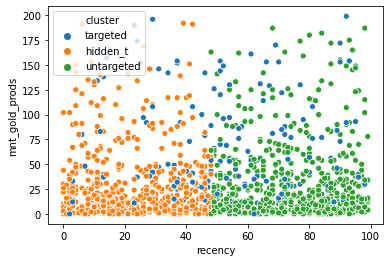

In [56]:
sns.scatterplot(data=new_df, x='recency', y='mnt_gold_prods', hue='cluster', palette='tab10');

In [112]:
pd.DataFrame( df_cluster.groupby('cluster')['mnt_gold_prods'].describe() )

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
hidden_t,800.0,36.396250,47.877495,0.0,7.0,18.5,43.0,362.0
targeted,457.0,71.317287,60.395607,0.0,27.0,48.0,103.0,249.0
untargeted,799.0,35.694618,45.491874,0.0,6.0,18.0,45.0,291.0


In [57]:
pd.DataFrame( df_cluster.groupby('cluster')['mnt_gold_prods'].quantile(.9) )

,mnt_gold_prods
cluster,
hidden_t,99.3
targeted,168.8
untargeted,99.0


### Number of Purchases
_total number of purchases made in the last 2 years_

- **targeted**
        They have bought more than 10 products i the last 2 years.

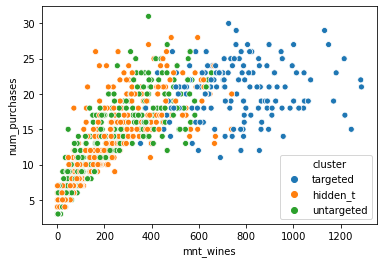

In [46]:
sns.scatterplot(data=new_df, x='mnt_wines', y='num_purchases', hue='cluster', palette='tab10');

In [139]:
pd.DataFrame( df_cluster.groupby('cluster')['num_purchases'].describe() )

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
hidden_t,800.0,10.682500,6.645253,0.0,5.0,8.0,16.0,29.0
targeted,457.0,19.921225,4.216500,9.0,17.0,20.0,23.0,32.0
untargeted,799.0,10.157697,6.199091,0.0,5.0,8.0,15.0,31.0


### Amount Spent
_sum of spends made in the last 2 years_

- **targeted**
        They have spent over R$ 484

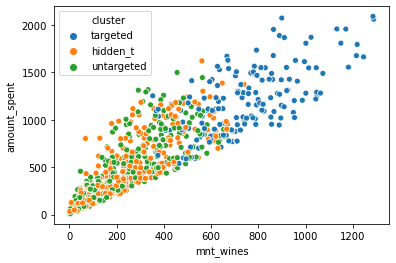

In [62]:
sns.scatterplot(data=new_df, x='mnt_wines', y='amount_spent', hue='cluster', palette='tab10');

In [146]:
pd.DataFrame( df_cluster.groupby('cluster')['amount_spent'].describe() )

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
hidden_t,800.0,340.233750,383.031664,5.0,41.0,154.0,546.0,1783.0
targeted,457.0,1379.155361,397.033628,484.0,1080.0,1358.0,1672.0,2491.0
untargeted,799.0,318.448060,361.617228,4.0,43.0,149.0,496.0,1657.0


In [63]:
pd.DataFrame( df_cluster.groupby('cluster')['amount_spent'].quantile(.9) )

,amount_spent
cluster,
hidden_t,960.1
targeted,1917.2
untargeted,900.0


### mean_amount_spent_per_month
_How much it's expected for the customer to spend each month he makes a purchase_

- **targeted**
        They spend at least R$ 27


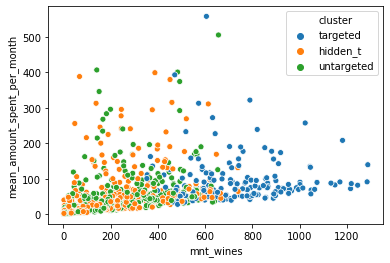

In [69]:
sns.scatterplot(data=new_df, x='mnt_wines', y='mean_amount_spent_per_month', hue='cluster', palette='tab10');

(-1.0, 200.0)

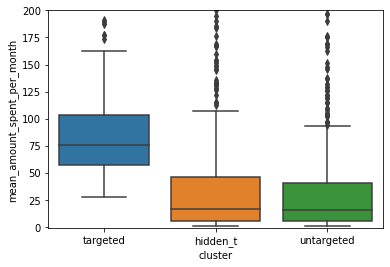

In [54]:
sns.boxplot(data=new_df, x='cluster', y='mean_amount_spent_per_month', palette='tab10');
plt.ylim(-1, 200)

In [151]:
pd.DataFrame( df_cluster.groupby('cluster')['mean_amount_spent_per_month'].describe() )

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
hidden_t,800.0,55.220335,118.362065,0.592105,5.186506,17.769013,50.303412,1103.0
targeted,457.0,192.485822,262.701559,27.897196,70.182482,96.774194,177.345133,2056.0
untargeted,799.0,48.730045,103.563590,0.270270,4.898759,16.904422,46.156284,996.0


In [157]:
untargeted['mean_amount_spent_per_month'].quantile(.62)

27.575768382751598

In [64]:
pd.DataFrame( df_cluster.groupby('cluster')['mean_amount_spent_per_month'].quantile(.9) )

,mean_amount_spent_per_month
cluster,
hidden_t,129.436133
targeted,443.159240
untargeted,102.337838


## spent_percentage_fruits
_percentage of amount spent in fruits_

- **targeted**
        They spend a maximum value of 16% of spending in fruits

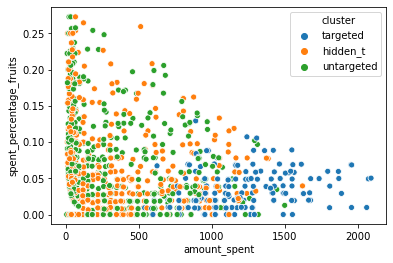

In [73]:
sns.scatterplot(data=new_df, x='amount_spent', y='spent_percentage_fruits', hue='cluster', palette='tab10');

In [167]:
pd.DataFrame( df_cluster.groupby('cluster')['spent_percentage_fruits'].describe() )

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
hidden_t,800.0,0.066226,0.083686,0.0,0.007984,0.035076,0.094320,0.762712
targeted,457.0,0.035458,0.030236,0.0,0.009896,0.028862,0.050119,0.169585
untargeted,799.0,0.066137,0.075012,0.0,0.009820,0.042254,0.097609,0.620690


In [74]:
pd.DataFrame( df_cluster.groupby('cluster')['spent_percentage_fruits'].quantile(.9) )

,spent_percentage_fruits
cluster,
hidden_t,0.180752
targeted,0.079555
untargeted,0.163022


### spent_percentage_fish
_percentage of amount spent in fish products_

- **targeted**
        They spend a maximum value of 20% of spending in fish products

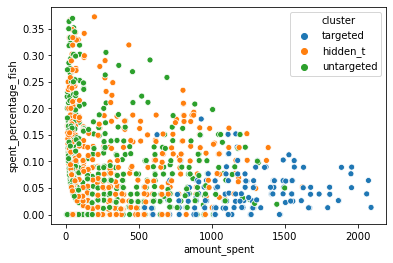

In [75]:
sns.scatterplot(data=new_df, x='amount_spent', y='spent_percentage_fish', hue='cluster', palette='tab10');

In [183]:
pd.DataFrame( df_cluster.groupby('cluster')['spent_percentage_fish'].describe() )

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
hidden_t,800.0,0.094626,0.109357,0.0,0.012932,0.062130,0.139724,0.750000
targeted,457.0,0.049798,0.043224,0.0,0.013029,0.038628,0.076401,0.218332
untargeted,799.0,0.093354,0.105703,0.0,0.016238,0.062500,0.135449,0.714286


In [76]:
pd.DataFrame( df_cluster.groupby('cluster')['spent_percentage_fish'].quantile(.9) )

,spent_percentage_fish
cluster,
hidden_t,0.231703
targeted,0.113971
untargeted,0.223955
